TODO:
- Fix time to detection metrics for series_length != 1
- base flow, linearoutputs, intermediate supervision

Backlog:
- look through early fires and add to omit_list
- Mask tile preds on omit list
- Add negative images from unlabeled fires
- Base flow as -40 image instead of first image
- Change smoke threshold

In [1]:
import matplotlib.pyplot as plt
import src.util_fns as util_fns
import pickle
import numpy as np
import cv2
import os
from pathlib import Path

In [2]:
metadata = pickle.load(open('./data/metadata.pkl', 'rb'))

raw_data_path = '/userdata/kerasData/data/new_data/raw_images/'
raw_labels_path = '/userdata/kerasData/data/new_data/drive_clone/'
labels_path = '/userdata/kerasData/data/new_data/pytorch_lightning_data/drive_clone_labels/'

labels_stats = pickle.load(open('./data/labels_stats.pkl', 'rb')) 
labels_stats_overlap = pickle.load(open('./data/labels_stats_overlap.pkl', 'rb')) 

example = labels_path+'20180504_FIRE_smer-tcs8-mobo-c/xml/1525469995_+00360.xml'

# Image Visualization

In [3]:
resize_dimensions = (1526, 2060)
crop_height = 1244
tile_dimensions = (224, 224)
tile_overlap = 20
num_tiles_height, num_tiles_width = util_fns.calculate_num_tiles(resize_dimensions, crop_height, tile_dimensions, tile_overlap)

In [4]:
def calculate_overlap_ticks(max_dim, tile_size=224, tile_overlap=20):
    i = 0
    dim = 0
    ticks = []

    while dim < max_dim:
        if i == 0:
            dim += tile_size-tile_overlap
        elif i % 2 == 1:
            dim += tile_overlap
        elif i % 2 == 0:
            dim += tile_size-tile_overlap*2

        ticks.append(dim)
        i += 1
    
    return ticks

In [5]:
def display_image(filename):
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    img = cv2.imread(filename)
    img = cv2.resize(img, (resize_dimensions[1],resize_dimensions[0]))[-crop_height:]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(16, 12), dpi=80)
    plt.xticks(calculate_overlap_ticks(resize_dimensions[1], tile_dimensions[1], tile_overlap))
    plt.yticks(calculate_overlap_ticks(resize_dimensions[0], tile_dimensions[0], tile_overlap))
    plt.imshow(img)
    plt.grid()

1037 20161113_FIRE_bl-n-mobo-c/1479065269_+00900
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 264   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


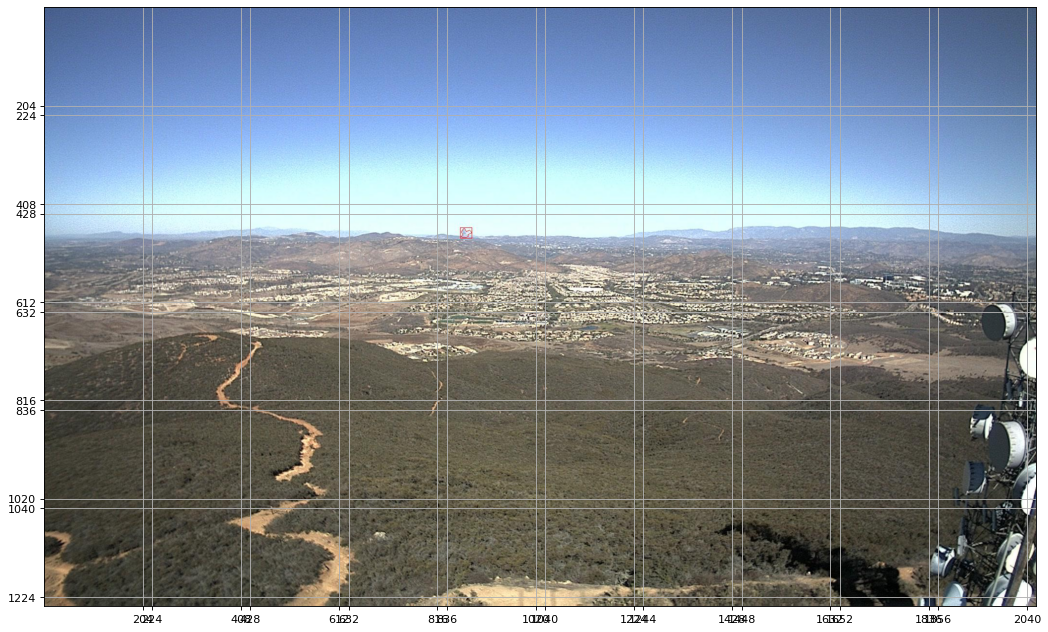

In [52]:
results_path = '/userdata/kerasData/src/pytorch-lightning-smoke-detection/saved_logs/version_109/'
image_preds = np.loadtxt(results_path+'image_preds.csv', delimiter=',', dtype=str)


for j, (image, image_pred) in enumerate(image_preds):
    if j < 1037: continue
    
    # Skip correct image predictions
#     if int(image_pred) != 0 or util_fns.get_ground_truth_label(image) != 1: continue
    
    print(j, image)
    
    # Save path variables
    raw_image_path = raw_data_path+image+'.jpg'
    label_path = labels_path+image+'.npy'
    label_image_path = raw_labels_path+util_fns.get_fire_name(image)+'/labels/'+util_fns.get_only_image_name(image)+'.jpg'
    tile_preds_path = results_path+'tile_preds/'+image+'.npy'
    
    # Load preds
    preds = np.load(tile_preds_path).reshape((num_tiles_height,num_tiles_width))
    print(preds)
    
    # Load gt labels (if not 0s)
    if Path(label_path).exists():
        labels = np.load(label_path)
        labels = cv2.resize(labels, (resize_dimensions[1],resize_dimensions[0]))[-crop_height:]
        labels = util_fns.tile_labels(labels, num_tiles_height, num_tiles_width, resize_dimensions, tile_dimensions, tile_overlap)
        labels = labels.sum((1,2))
        labels = labels.reshape((num_tiles_height,num_tiles_width))
        print(labels)
    
    # Load image
    if Path(label_image_path).exists():
        display_image(label_image_path)
    elif Path(raw_image_path).exists():
        display_image(raw_image_path)
        
    break

/tmp/ipykernel_3028/1729858501.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(4, 4), dpi=20)


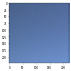

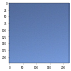

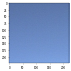

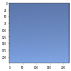

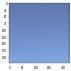

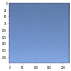

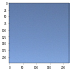

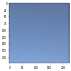

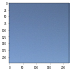

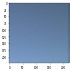

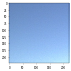

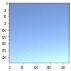

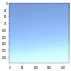

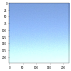

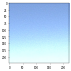

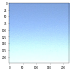

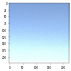

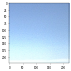

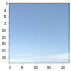

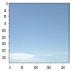

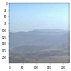

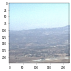

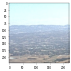

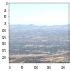

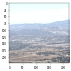

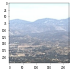

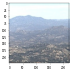

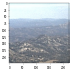

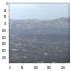

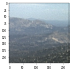

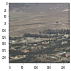

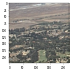

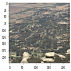

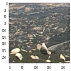

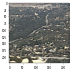

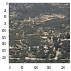

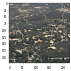

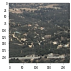

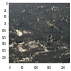

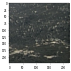

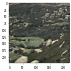

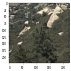

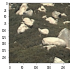

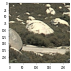

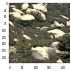

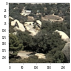

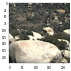

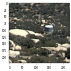

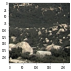

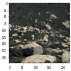

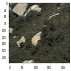

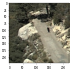

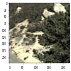

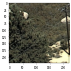

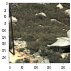

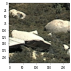

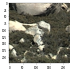

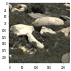

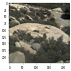

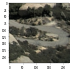

In [43]:
for fire in metadata['fire_to_images']:
    image = metadata['fire_to_images'][fire][0]
    raw_image_path = raw_data_path+image+'.jpg'
    display_tiles(raw_image_path)
    break

In [47]:
for i in range(20):
    print(224*i, 224+(i-1)*204)
    

0 20
224 224
448 428
672 632
896 836
1120 1040
1344 1244
1568 1448
1792 1652
2016 1856
2240 2060
2464 2264
2688 2468
2912 2672
3136 2876
3360 3080
3584 3284
3808 3488
4032 3692
4256 3896


In [42]:
def display_tiles(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    original_img = cv2.imread(filename)
    original_img = cv2.resize(original_img, (2060,1536))[-1244:]
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

#     original_img = original_img.reshape((5, 224, 9, 224, 3)).swapaxes(1,2).reshape((-1,224,224,3))
    
#     original_img = np.transpose(original_img, (2,0,1))
    
    bytelength = original_img.nbytes // original_img.size
    
    original_img = np.lib.stride_tricks.as_strided(
                    original_img, 
                    shape=( 
                           6, 
                           10, 
                           224, 
                           224,3), 
                    strides=(2060*204*bytelength*3,
                             204*bytelength*3, 
                             2060*bytelength*3, 
                             bytelength*3, 
                             bytelength)).reshape((-1, 224, 224, 3))
#     original_img = np.transpose(original_img.reshape((3, -1, 224,224)), (1,2,3,0))


#     original_img = np.lib.stride_tricks.sliding_window_view(original_img, (224,224), axis=(0,1))[::224, ::224]
#     original_img = original_img.reshape(-1, 224, 224, 3)
    
    for tile in original_img:
        plt.figure(figsize=(4, 4), dpi=20)
        plt.imshow(tile)